In [10]:
# Import all the necessary libraries
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# Do not print warnings
warnings.filterwarnings('ignore')

##### Read the necessary datasets

In [11]:
causal_prior = pd.read_csv('data/CausalPriorFiltered.csv')
gene_status = pd.read_csv('data/OncoKBCancerGeneList.csv')
site_effects = pd.read_csv('data/SiteEffects.csv')

In [23]:
site_effects[site_effects['HugoSymbol'] == "RAF1"]

,HugoSymbol,Location,InteractionType,Status
4568,RAF1,S259,PHOSPHORYLATION,-1
4569,RAF1,S287,PHOSPHORYLATION,1
4570,RAF1,S289,PHOSPHORYLATION,1
4571,RAF1,S29,PHOSPHORYLATION,-1
4572,RAF1,S291,PHOSPHORYLATION,1
4573,RAF1,S296,PHOSPHORYLATION,1
4574,RAF1,S301,PHOSPHORYLATION,-1
4575,RAF1,S338,PHOSPHORYLATION,1
4576,RAF1,S339,PHOSPHORYLATION,1
4577,RAF1,S359,PHOSPHORYLATION,-1


In [12]:
def getGeneType(geneName):
    ''' This function returns -1 -> Tumor Supressor Gene
                                1 -> Oncogene
                                0 -> For Both
                                -2 -> For Not Both
                                -3 -> For Unknown
    '''
    DownGeneLabel = pd.read_csv('data/OncoKBCancerGeneList.csv')
    a = DownGeneLabel.loc[(DownGeneLabel['HugoSymbol']) == (geneName)]

    if(a.empty):
        return -3

    isOncogene = (a['IsOncogene']).iloc[0]
    isTumorSupressor = (a['IsTumorSuppressorGene']).iloc[0]

    if(isOncogene == 'No' and isTumorSupressor == 'Yes'):
        return -1
    elif(isOncogene == 'Yes' and isTumorSupressor == 'No'):
        return 1
    elif(isOncogene == 'Yes' and isTumorSupressor == 'Yes'):
        return 0
    elif(isOncogene == 'No' and isTumorSupressor == 'No'):
        return -2


def upstream_gene_status(geneName):
    # Return if gene is neither Oncogene or Tumor Supressor
    geneType = getGeneType(geneName)
    if(geneType == 0 or geneType == -2 or geneType == -3):
        print('The gene is neither Oncogene or Tumor Supressor')
        return

    # Get upstream genes
    up_genes = causal_prior[causal_prior['Output'] == geneName]
    up_genes.reset_index(drop=True, inplace=True)

    # Decode InteractionType to 1 and -1
    up_genes['InteractCode'] = 0
    up_genes['InteractCode'] = up_genes['InteractionType'].apply(lambda x: 1 if str(x) == 'phosphorylates' or str(x) == 'acetylates' or str(x) == 'methylates' else -1)

    # Construct a new column i.e. 'Sites' splitting sites of each gene
    up_genes['Sites'] = ''
    up_genes['Sites'] = up_genes['Location'].str.split(';')

    # Extract site information of that Gene geneName
    gene_sites = site_effects[site_effects['HugoSymbol'] == geneName]
    gene_sites.reset_index(drop=True, inplace=True)

    # Take the Activating or Inhibiting status(1, -1) from gene_sites and put into up_genes['Sites']
    up_genes['SiteStatus'] = ''
    sites = {}
    for index, row in gene_sites.iterrows():
        sites[row['Location']] = row['Status']

    for index, row in up_genes.iterrows():
        temp  = []
        for site in row['Sites']:
            if(site in sites):
                temp.append(sites[site])
            else:
                temp.append(0)
        up_genes.at[index, 'SiteStatus'] = temp

    # Add another column for Tumor Suppressor or Oncogene label
    up_genes['DownGeneLabel'] = geneType

    # Now finally doing computation
    up_genes['Result'] = ''
    for index, row in up_genes.iterrows():
        temp  = []
        for site in row['SiteStatus']:
            result = int(site) * int(row['InteractCode']) * int(row['DownGeneLabel'])
            temp.append(result)

        up_genes.at[index, 'Result'] = temp

    # Labal genes type
    up_genes['RootGeneLabel'] = ''
    for index, row in up_genes.iterrows():
        up_genes.at[index, 'RootGeneLabel'] = getGeneType(row['Gene'])

    return up_genes

In [13]:
def get_information_from_down_gene(gene):
    # Lets get all the downstream gene of gene
    down_nodes = causal_prior[causal_prior['Gene'] == gene]
    down_nodes.reset_index(drop=True, inplace=True)
    
    # filter genes which is listed in OncoKBCancerGeneList
    col1 = []
    col2 = []
    for i in down_nodes['Output']:
        if(getGeneType(i) == 1 or getGeneType(i) == -1):
            col1.append(i)
            col2.append(getGeneType(i))
    down_known_gene = pd.DataFrame(list(zip(col1, col2)), columns=['Gene', 'Type'])
    
    # final step is to get status from genes
    final_result = pd.DataFrame()
    for i in down_known_gene['Gene']:
        output = upstream_gene_status(i)
        result = output.loc[output['Gene'] == gene]
        final_result = final_result.append(result, ignore_index=True)

    return final_result

In [14]:
get_information_from_down_gene("RB1")

,Gene,InteractionType,Output,Location,InteractCode,Sites,SiteStatus,DownGeneLabel,Result,RootGeneLabel
0,RB1,phosphorylates,MDM2,S395,1,[S395],[-1],1,[-1],-1
1,RB1,dephosphorylates,MDM2,S269;S260,-1,"[S269, S260]","[0, 1]",1,"[0, -1]",-1
2,RB1,dephosphorylates,ARID4A,S1007;S864,-1,"[S1007, S864]","[-1, -1]",-1,"[-1, -1]",-1
3,RB1,phosphorylates,MDM2,S395,1,[S395],[-1],1,[-1],-1
4,RB1,dephosphorylates,MDM2,S269;S260,-1,"[S269, S260]","[0, 1]",1,"[0, -1]",-1


In [22]:
output = pd.DataFrame()
genes = causal_prior['Gene'].unique()
for gene in genes:
    a = get_information_from_down_gene(gene)
    output = output.append(a, ignore_index=True)
output

,Gene,InteractionType,Output,Location,InteractCode,Sites,SiteStatus,DownGeneLabel,Result,RootGeneLabel
0,RAF1,phosphorylates,RB1,S608,1,[S608],[0],-1,[0],1
1,RAF1,phosphorylates,MYC,T8,1,[T8],[0],1,[0],1
2,RAF1,phosphorylates,HRAS,Y137,1,[Y137],[0],1,[0],1
3,RAF1,phosphorylates,MAP2K2,S226;S222,1,"[S226, S222]","[1, 1]",1,"[1, 1]",1
4,RAF1,phosphorylates,MAP2K1,S218;T292;S298;S222;T286;T386,1,"[S218, T292, S298, S222, T286, T386]","[1, -1, 1, 1, -1, 0]",1,"[1, -1, 1, 1, -1, 0]",1
...,...,...,...,...,...,...,...,...,...,...
5984,ELF1,dephosphorylates,RB1,T821;T826,-1,"[T821, T826]","[1, -1]",-1,"[1, -1]",-3
5985,FOXM1,acetylates,TP53,K373,1,[K373],[-1],-1,[1],-3
5986,KAT6A,acetylates,TP53,K382;K120,1,"[K382, K120]","[-1, -1]",-1,"[1, 1]",-2
5987,DNMT3A,phosphorylates,MECOM,S436,1,[S436],[0],1,[0],-1


In [16]:
output.to_csv('data/outputs/final/final_result.csv', index=False)

In [17]:
get_information_from_down_gene('RAF1')

,Gene,InteractionType,Output,Location,InteractCode,Sites,SiteStatus,DownGeneLabel,Result,RootGeneLabel
0,RAF1,phosphorylates,RB1,S608,1,[S608],[0],-1,[0],1
1,RAF1,phosphorylates,MYC,T8,1,[T8],[0],1,[0],1
2,RAF1,phosphorylates,HRAS,Y137,1,[Y137],[0],1,[0],1
3,RAF1,phosphorylates,MAP2K2,S226;S222,1,"[S226, S222]","[1, 1]",1,"[1, 1]",1
4,RAF1,phosphorylates,MAP2K1,S218;T292;S298;S222;T286;T386,1,"[S218, T292, S298, S222, T286, T386]","[1, -1, 1, 1, -1, 0]",1,"[1, -1, 1, 1, -1, 0]",1
5,RAF1,phosphorylates,BCL2L11,S602;T599,1,"[S602, T599]","[0, 0]",-1,"[0, 0]",1
6,RAF1,phosphorylates,MAPK1,T182;S29;T185;Y184;Y187,1,"[T182, S29, T185, Y184, Y187]","[0, 1, 1, 0, 1]",1,"[0, 1, 1, 0, 1]",1
7,RAF1,phosphorylates,MAPK3,Y204;Y203;T202;T201,1,"[Y204, Y203, T202, T201]","[1, 0, 1, 0]",1,"[1, 0, 1, 0]",1
8,RAF1,dephosphorylates,BRAF,T753;T401;S750;S151,-1,"[T753, T401, S750, S151]","[-1, -1, -1, -1]",1,"[1, 1, 1, 1]",1
9,RAF1,dephosphorylates,KRAS,S181,-1,[S181],[1],1,[-1],1


##### Doing varios analysis on the resultant dataset

In [28]:
output = pd.read_csv('data/outputs/final/final_result.csv')

output['LabelStat'] = ''
output['Predicted'] = ''
for index, row in output.iterrows():
    d = {1: 0, -1: 0, 0: 0}
    for item in row['Result']:
        if(int(float(item)) == 1):
            d[1] += 1
        if(int(float(item)) == -1):
            d[-1] += 1
        if(int(float(item)) == 0):
            d[0] += 1
    output.at[index, 'LabelStat'] = d
    output.at[index, 'Predicted'] = max(d, key=d.get)

output

ValueError: could not convert string to float: '['

False    4663
True     1326
dtype: int64


<AxesSubplot:>

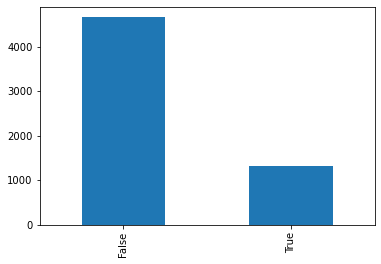

In [19]:
stats= output['RootGeneLabel'] == output['Predicted']

print(stats.value_counts())
pd.value_counts(stats).plot.bar()

In [21]:
output[output['Gene'] == 'RAF1']

,Gene,InteractionType,Output,Location,InteractCode,Sites,SiteStatus,DownGeneLabel,Result,RootGeneLabel,LabelStat,Predicted
0,RAF1,phosphorylates,RB1,S608,1,['S608'],[0],-1,[0],1,"{1: 0, -1: 0, 0: 0}",1
1,RAF1,phosphorylates,MYC,T8,1,['T8'],[0],1,[0],1,"{1: 0, -1: 0, 0: 0}",1
2,RAF1,phosphorylates,HRAS,Y137,1,['Y137'],[0],1,[0],1,"{1: 0, -1: 0, 0: 0}",1
3,RAF1,phosphorylates,MAP2K2,S226;S222,1,"['S226', 'S222']","[1, 1]",1,"[1, 1]",1,"{1: 0, -1: 0, 0: 0}",1
4,RAF1,phosphorylates,MAP2K1,S218;T292;S298;S222;T286;T386,1,"['S218', 'T292', 'S298', 'S222', 'T286', 'T386']","[1, -1, 1, 1, -1, 0]",1,"[1, -1, 1, 1, -1, 0]",1,"{1: 0, -1: 0, 0: 0}",1
5,RAF1,phosphorylates,BCL2L11,S602;T599,1,"['S602', 'T599']","[0, 0]",-1,"[0, 0]",1,"{1: 0, -1: 0, 0: 0}",1
6,RAF1,phosphorylates,MAPK1,T182;S29;T185;Y184;Y187,1,"['T182', 'S29', 'T185', 'Y184', 'Y187']","[0, 1, 1, 0, 1]",1,"[0, 1, 1, 0, 1]",1,"{1: 0, -1: 0, 0: 0}",1
7,RAF1,phosphorylates,MAPK3,Y204;Y203;T202;T201,1,"['Y204', 'Y203', 'T202', 'T201']","[1, 0, 1, 0]",1,"[1, 0, 1, 0]",1,"{1: 0, -1: 0, 0: 0}",1
8,RAF1,dephosphorylates,BRAF,T753;T401;S750;S151,-1,"['T753', 'T401', 'S750', 'S151']","[-1, -1, -1, -1]",1,"[1, 1, 1, 1]",1,"{1: 0, -1: 0, 0: 0}",1
9,RAF1,dephosphorylates,KRAS,S181,-1,['S181'],[1],1,[-1],1,"{1: 0, -1: 0, 0: 0}",1


In [20]:
summary = pd.DataFrame(columns=['Gene', 'OncoPredictsGenes', 'TMPredictsGenes', 'BothCount'])
previous = ''
current = 'Any'
for index, row in output.iterrows():
    d = {1: 0, -1: 0, 0: 0}
    current = row['Gene']
    if(current != previous):
        temp = pd.DataFrame(data={'Gene':[], 'OncoPredictsGenes':[], 'TMPredictsGenes':[], 'BothCount':[]})


In [27]:
int(float('-1'))

-1